# Formen

In [1]:
%pylab inline
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3

import sys, os
sys.path.append("/Python")
from myfunctions import *

con = sqlite3.connect("../data/CongoDB.sqlite")

Populating the interactive namespace from numpy and matplotlib


## Gefäßform

In [98]:
sql = """SELECT
           t_Obj.objID, 
           t_Obj.Art,
           t_Obj.Scherbe,
           t_Obj.Anzahl,
           t_Obj.Form_Gef
       FROM (t_Ort INNER JOIN t_Komplex ON t_Ort.ortID = t_Komplex.ortID)
           INNER JOIN t_Obj ON t_Komplex.komplexID = t_Obj.komplexID
       WHERE (((t_Ort.ort_lit)='DS')
           AND ((t_Obj.Art) = "K")
           AND ((t_Obj.Notiz) Not Like '%1987%'))""".replace('\n',' ')

df = pd.read_sql(sql, con)
df['Anzahl'] = df['Anzahl'].convert_objects(convert_numeric=True)
df['Form_Gef'] = df['Form_Gef'].replace('', np.nan, regex=True)

a = pd.Series({'bestimmt':(len(df['Form_Gef']) - df['Form_Gef'].isnull().sum()),
               'unbestimmt':df['Form_Gef'].isnull().sum()})
a = pd.DataFrame(a)
a['Prozent'] = a[0]/a[0].sum()*100
a

C:\Users\DirkSeidenticker\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


,0,Prozent
bestimmt,2142,40.415094
unbestimmt,3158,59.584906


In [40]:
sql = """SELECT
           t_Obj.objID,
           t_Obj.Form_Gef
       FROM (t_Ort INNER JOIN t_Komplex ON t_Ort.ortID = t_Komplex.ortID)
           INNER JOIN t_Obj ON t_Komplex.komplexID = t_Obj.komplexID
       WHERE (((t_Ort.ort_lit)='DS')
           AND ((t_Obj.Form_Gef) != '')
           AND ((t_Obj.Form_Gef) Not Like '%/%')
           AND ((t_Obj.Form_Gef) Not Like '% (?)%'))""".replace('\n',' ')

df = pd.read_sql(sql, con)

In [41]:
# sicher bestimmte Gef-Formen
len(df)

926

In [42]:
df['Gef1'] = df['Form_Gef'].str[0]
df['Gef2'] = df['Form_Gef'].str[1]

In [43]:
df_pivot = df.pivot_table(values = 'objID', index = 'Gef1', columns = 'Gef2', aggfunc = len)
df_pivot = pd.DataFrame(df_pivot)
df_pivot

Gef2,1,2,3,4,5,6,7
Gef1,,,,,,,
A,3.0,9.0,53.0,NaN,NaN,NaN,NaN
B,2.0,11.0,21.0,124.0,1.0,1.0,3.0
C,18.0,82.0,NaN,NaN,NaN,NaN,NaN
D,91.0,30.0,NaN,NaN,NaN,NaN,NaN
E,6.0,12.0,25.0,4.0,6.0,16.0,1.0
F,3.0,2.0,42.0,3.0,2.0,4.0,2.0
G,12.0,16.0,39.0,68.0,2.0,26.0,NaN
H,5.0,42.0,NaN,NaN,NaN,NaN,NaN
I,13.0,3.0,46.0,62.0,NaN,NaN,NaN


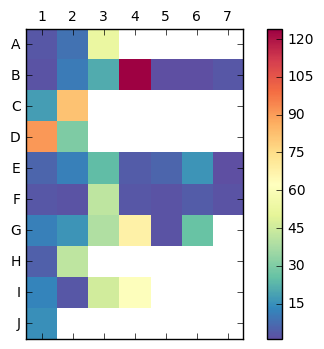

In [44]:
fig, ax1 = plt.subplots()
im = ax1.imshow(df_pivot, interpolation='nearest', cmap='Spectral_r')
plt.colorbar(im)
plt.yticks(range(len(df_pivot.index)), df_pivot.index)
plt.xticks(range(len(df_pivot.columns)), df_pivot.columns)
ax1.tick_params(labeltop='on', labelbottom='off')
plt.show()

In [47]:
cmap = plt.get_cmap('gray_r')
new_cmap = truncate_colormap(cmap, 0, 0.4)

In [58]:
# Beschriftung für die Zellen separat erstellen:
df_pivot_a = df_pivot
df_pivot_a = df_pivot_a.replace(np.nan, 0)
df_pivot_a = df_pivot_a.round(0)
df_pivot_a = df_pivot_a.astype(int)
df_pivot_a = df_pivot_a.replace(0, '-')

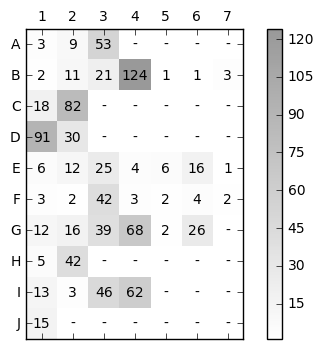

In [60]:
fig, ax1 = plt.subplots()
im = ax1.imshow(df_pivot, interpolation='nearest', cmap=new_cmap)
plt.colorbar(im)
plt.yticks(range(len(df_pivot.index)), df_pivot.index)
plt.xticks(range(len(df_pivot.columns)), df_pivot.columns)
ax1.tick_params(labeltop='on', labelbottom='off')

for (i, j), z in np.ndenumerate(df_pivot_a):
    plt.text(j, i, z, ha='center', va='center')

plt.savefig('../output/figs/2-2-1_Keramik_Gef-Formen.pdf', bbox_inches='tight')
plt.show()

## Randformen

In [204]:
sql = """SELECT
           t_Obj.objID,
           t_Obj.Form_Rand
       FROM (t_Ort INNER JOIN t_Komplex ON t_Ort.ortID = t_Komplex.ortID)
           INNER JOIN t_Obj ON t_Komplex.komplexID = t_Obj.komplexID
       WHERE (((t_Ort.ort_lit)='DS')
           AND ((t_Obj.Form_Rand) != ''))""".replace('\n',' ')

df = pd.read_sql(sql, con)

In [205]:
# Alle Varianten ermitteln
# (?) und Leeranschläge löschen
df['FormRand'] = df['Form_Rand'].map(lambda x: x.rstrip('(?)'))
df['FormRand'] = df['FormRand'].map(lambda x: x.strip(' '))

In [206]:
# Kombinationen in separate Zeilen auflösen
# siehe http://stackoverflow.com/questions/17116814/pandas-how-do-i-split-text-in-a-column-into-multiple-rows
from pandas import Series, DataFrame
s = df['FormRand'].str.split('/').apply(Series, 1).stack()
s.index = s.index.droplevel(-1) # to line up with df's index
s.name = 'FormRand'
del df['FormRand']
df = df.join(s)

In [207]:
df_pivot = df.pivot_table(values = 'objID', columns = 'FormRand', aggfunc = len)
df_pivot = pd.DataFrame(df_pivot)

Anzahl der Randformen:

In [208]:
len(df_pivot)

36

In [209]:
df_pivot.sort_values(by = 'objID', ascending = False).plot(kind = 'bar')

In [210]:
# df_pivot['objID'] = df_pivot['objID'].apply(lambda x: pd.to_numeric(x, errors='ignore'))
df_pivot['pct'] = df_pivot['objID'] / df_pivot['objID'].sum() * 100
df_pivot = df_pivot.sort_values(by = 'objID', ascending = False)
df_pivot.head(10)

,objID,pct
FormRand,,
B1,751,24.777301
B2,404,13.328934
B1.1,357,11.778291
A1,306,10.095678
B3,194,6.400528
A2,124,4.091059
C3,107,3.530188
A4.3,99,3.266249
B1.5,83,2.738370


In [214]:
# nur jene Formen, mit weniger als 10%-Anteilen + Summe dieser Varianten (Wie viel machen sie zusammengenommen aus?)
df_pivot.loc[df_pivot['pct'] < 10].sum()

objID    1213.000000
pct        40.019795
dtype: float64

### Grundformen

In [186]:
# nur Grundform behalten: alles hinter der 2. Stelle abschneiden
df['FormGrundRand'] = df['FormRand'].map(lambda x: str(x)[:2])
df_pivot = df.pivot_table(values = 'objID', columns = 'FormGrundRand', aggfunc = len)
df_pivot = pd.DataFrame(df_pivot)

In [187]:
len(df_pivot)

10

In [189]:
# df_pivot['objID'] = df_pivot['objID'].apply(lambda x: pd.to_numeric(x, errors='ignore'))
df_pivot['pct'] = df_pivot['objID'] / df_pivot['objID'].sum() * 100
df_pivot = df_pivot.sort_values(by = 'objID', ascending = False)
df_pivot

,objID,pct
FormGrundRand,,
B1,1285,42.395249
B2,528,17.419993
A1,332,10.953481
B3,263,8.677004
A2,238,7.852194
A4,152,5.014847
C3,108,3.563180
C1,83,2.738370
A3,33,1.088750


In [193]:
# nur Ausrichtung behalten: alles hinter der 1. Stelle abschneiden
df['FormAusrichtungRand'] = df['FormRand'].map(lambda x: str(x)[:1])
df_pivot = df.pivot_table(values = 'objID', columns = 'FormAusrichtungRand', aggfunc = len)
df_pivot = pd.DataFrame(df_pivot)
df_pivot['pct'] = df_pivot['objID'] / df_pivot['objID'].sum() * 100
df_pivot = df_pivot.sort_values(by = 'objID', ascending = False)
df_pivot

,objID,pct
FormAusrichtungRand,,
B,2076,68.492247
A,755,24.909271
C,200,6.598482


## Randlippe / Mündung

In [220]:
sql = """SELECT
           t_Obj.objID,
           t_Obj.Form_Mdg
       FROM (t_Ort INNER JOIN t_Komplex ON t_Ort.ortID = t_Komplex.ortID)
           INNER JOIN t_Obj ON t_Komplex.komplexID = t_Obj.komplexID
       WHERE (((t_Ort.ort_lit)='DS')
           AND ((t_Obj.Form_Mdg) != ''))""".replace('\n',' ')

df = pd.read_sql(sql, con)

In [222]:
# nur Hauptform behalten: alles hinter der 2. Stelle abschneiden
df['FormMdgGrund'] = df['Form_Mdg'].map(lambda x: str(x)[:2])
df_pivot = df.pivot_table(values = 'objID', columns = 'FormMdgGrund', aggfunc = len)
df_pivot = pd.DataFrame(df_pivot)
df_pivot['pct'] = df_pivot['objID'] / df_pivot['objID'].sum() * 100
df_pivot = df_pivot.sort_values(by = 'objID', ascending = False)
df_pivot

,objID,pct
FormMdgGrund,,
M3,619,26.441692
M1,503,21.486544
M2,456,19.478855
M5,357,15.249893
M4,315,13.455788
M6,91,3.887228


## Bodenformen

### Anzahl GE mit bestimmter Bodenform

In [81]:
sql = """SELECT
           t_Obj.objID,
           t_Obj.Form_Boden
       FROM (t_Ort INNER JOIN t_Komplex ON t_Ort.ortID = t_Komplex.ortID)
           INNER JOIN t_Obj ON t_Komplex.komplexID = t_Obj.komplexID
       WHERE (((t_Ort.ort_lit)='DS')
           AND ((t_Obj.Art) = "K"))""".replace('\n',' ')

df = pd.read_sql(sql, con)

In [82]:
a = pd.Series({'bestimmt':len(df.loc[~df['Form_Boden'].isnull()]),
               'unbestimmt':len(df.loc[df['Form_Boden'].isnull()])})
a = pd.DataFrame(a)
a['Prozent'] = a[0]/a[0].sum()*100
a

,0,Prozent
bestimmt,343,6.384959
unbestimmt,5029,93.615041


### Häufigkeiten

In [93]:
sql = """SELECT
           t_Obj.objID,
           t_Obj.Form_Boden
       FROM (t_Ort INNER JOIN t_Komplex ON t_Ort.ortID = t_Komplex.ortID)
           INNER JOIN t_Obj ON t_Komplex.komplexID = t_Obj.komplexID
       WHERE (((t_Ort.ort_lit)='DS')
           AND ((t_Obj.Form_Boden) != '')
           AND ((t_Obj.Form_Boden) Not Like '%/%')
           AND ((t_Obj.Form_Boden) Not Like '% (?)%'))""".replace('\n',' ')

df = pd.read_sql(sql, con)

df_pivot = df.pivot_table(values = 'objID', columns = 'Form_Boden', aggfunc = len, fill_value = '')
df_pivot = pd.DataFrame(df_pivot)
df_pivot['pct'] = df_pivot/df_pivot.sum()*100
df_pivot.sort_values(by = 'pct',ascending = False)

,objID,pct
Form_Boden,,
B1,151,48.709677
B4,75,24.193548
B2,19,6.129032
B13,18,5.806452
B6,17,5.483871
B11,6,1.935484
B5,5,1.612903
B8,5,1.612903
B3,4,1.290323


In [95]:
len(df_pivot)

14

## Sicher bestimmte Bodentypen von sicher bestimmten Stilgruppen

In [2]:
sql = """SELECT
           t_Ort.ort_kurz,
           t_Ort.ort_name,
           t_Obj.objID,
           t_Obj.Typ,
           t_Obj.Form_Boden,
           t_Obj.Form_Gef
       FROM (t_Ort INNER JOIN t_Komplex ON t_Ort.ortID = t_Komplex.ortID)
           INNER JOIN t_Obj ON t_Komplex.komplexID = t_Obj.komplexID
       WHERE (((t_Ort.ort_lit)='DS')
           AND ((t_Obj.Form_Boden) != '')
           AND ((t_Obj.Form_Boden) Not Like '%/%')
           AND ((t_Obj.Form_Boden) Not Like '% (?)%')
           AND ((t_Obj.Typ) Not Like '% (?)%')
           AND ((t_Obj.Typ) Not Like '%/%')
           AND ((t_Obj.Typ) != ''))""".replace('\n',' ')

df = pd.read_sql(sql, con)

df_pivot = df.pivot_table(values = 'objID', index = 'Typ', columns = 'Form_Boden', aggfunc = len, fill_value = '')
#df_pivot = df_pivot.reset_index()
#df_pivot = df_pivot.set_index(['Typ'])
df_pivot

Form_Boden,B1,B11,B13,B2,B4,B5,B6,B8
Typ,,,,,,,,
BAN,1,,,,1,1,,
BBS,1,,,,,,1,
BRU,,,,,1,,,
BTM,,1,,2,6,1,,
DAM,7,,,,1,,1,
DON,,,,1,,,,
EBA,2,,1,1,7,,11,
EPE,2,,1,1,19,1,1,1
KPT,1,,,,,,,


In [3]:
df_pivot = df_pivot.replace('', np.nan, regex = True)

In [4]:
df_pivot = df_pivot.transpose()
plt.imshow(df_pivot, interpolation='nearest', cmap='Spectral_r')
plt.yticks(range(len(df_pivot.index)), df_pivot.index)
plt.xticks(range(len(df_pivot.columns)), df_pivot.columns, rotation='vertical')
plt.colorbar(orientation='horizontal')
plt.show()

## Boden == B11

In [3]:
sql = """SELECT
           t_Ort.ort_kurz,
           t_Ort.ort_name,
           t_Obj.objID,
           t_Obj.Typ,
           t_Obj.Form_Mdg,
           t_Obj.Form_Rand,
           t_Obj.Form_Hals,
           t_Obj.Form_Schulter,
           t_Obj.Form_Bauch,
           t_Obj.Form_Boden,
           t_Obj.Form_Gef
       FROM (t_Ort INNER JOIN t_Komplex ON t_Ort.ortID = t_Komplex.ortID)
           INNER JOIN t_Obj ON t_Komplex.komplexID = t_Obj.komplexID
       WHERE (((t_Ort.ort_lit)='DS')
           AND ((t_Obj.Form_Boden) Like '%B11%'))""".replace('\n',' ')

df = pd.read_sql(sql, con)

display(df)

,ort_kurz,ort_name,objID,Typ,Form_Mdg,Form_Rand,Form_Hals,Form_Schulter,Form_Bauch,Form_Boden,Form_Gef
0,BLK,Boleko,1470,BOT (?),M3,R7c alt,,,B1/D1,B11,G2g
1,INS,Inyenge,4663,None,,None,,,,B11,
2,KOU,Kouango,5472,None,,None,,,A1 (?),B11,
3,KOU,Kouango,5473,None,,None,,,A1 (?),B11,
4,KOU,Kouango,5474,None,,None,,,A1 (?),B11,
5,MKL,Mokelo,5596,BTM,,None,,,A1,B11,


In [4]:
df_pivot = df.pivot_table(values = 'objID', index = 'Form_Boden', aggfunc = len)
df_pivot

Form_Boden
B11    6
Name: objID, dtype: int64

## Boden == B15

In [2]:
sql = """SELECT
           t_Ort.ort_kurz,
           t_Ort.ort_name,
           t_Obj.objID,
           t_Obj.Typ,
           t_Obj.Form_Mdg,
           t_Obj.Form_Rand,
           t_Obj.Form_Hals,
           t_Obj.Form_Schulter,
           t_Obj.Form_Bauch,
           t_Obj.Form_Boden,
           t_Obj.Form_Gef
       FROM (t_Ort INNER JOIN t_Komplex ON t_Ort.ortID = t_Komplex.ortID)
           INNER JOIN t_Obj ON t_Komplex.komplexID = t_Obj.komplexID
       WHERE (((t_Ort.ort_lit)='DS')
           AND ((t_Obj.Form_Boden) Like '%B15%'))""".replace('\n',' ')

df = pd.read_sql(sql, con)

display(df)

,ort_kurz,ort_name,objID,Typ,Form_Mdg,Form_Rand,Form_Hals,Form_Schulter,Form_Bauch,Form_Boden,Form_Gef
0,LKK,Lokekya,204,BKW (?),M6/M1,A1,,,B1/E1/A1,B15,G2 (?)
1,BKW,Bokwango,1469,BKW,M1,B1.1,X,A1,D2,B15,None
